# Coin Flips
Perry Grossman
3/26/2018
- Twitter: [@perrygrossman](https://twitter.com/perrygrossman)

using: 
#####  Bayesian Statistical Analysis with PyMC3
Eric J. Ma,

PyCon 2017, Portland, OR; PyData Boston 2017, Boston, MA

- HTML Notebook on GitHub: [**ericmjl**.github.io/**bayesian-stats-talk**](https://ericmjl.github.io/bayesian-stats-talk)
- Twitter: [@ericmjl](https://twitter.com/ericmjl)

In [19]:
# Imports
import pymc3 as pm
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import seaborn as sns
import missingno as msno   ####################

import random

# Set plotting style
# plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context('poster')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import png

In [21]:
import pyqrcode as pq
icon = pq.create('https://ericmjl.github.io/bayesian-stats-talk')


## bayesian thinking

> update beliefs having seen the evidence

# problem type 1: parameter estimation

"is the true value equal to X?"

OR

"given the data, for the parameter of interest, what is the probability distribution over the possible values?"

# example 1: the obligatory coin toss problem

I tossed my coin $ n $ times, and it came up as heads $ h $ times. Is it biased?

## parameterized problem

"I want to know $ p $, the probability of tossing heads. Given $ n $ tosses and $ h $ observed heads, is it probable that the value of $ p $ is close to $ 0.5$ , say, in the interval $[0.48, 0.52]$?"

## prior

- prior belief about parameter: $ p \sim Uniform(0, 1) $
- likelihood function: $ data \sim Bernoulli(p) $

![asdf](coin_model.jpg)

In [37]:
total = random.randint(1,10000)
total

1122

In [38]:
n_heads = random.randint(1,total)
n_heads

946

In [39]:
# Make the data needed for the problem.
from random import shuffle
#total = 3000
#n_heads = 1500
n_tails = total - n_heads
tosses = [1] * n_heads + [0] * n_tails
shuffle(tosses)

In [40]:
highest = max(n_heads, n_tails)
highest

946

## data

In [41]:
print(tosses)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 

In [42]:
def plot_coins():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(list(Counter(tosses).keys()), list(Counter(tosses).values()))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['tails', 'heads'])
    ax.set_ylim(0, highest)
    ax.set_yticks(np.arange(0, round(highest*1.20,0),round(highest*0.1,0)))
    return fig

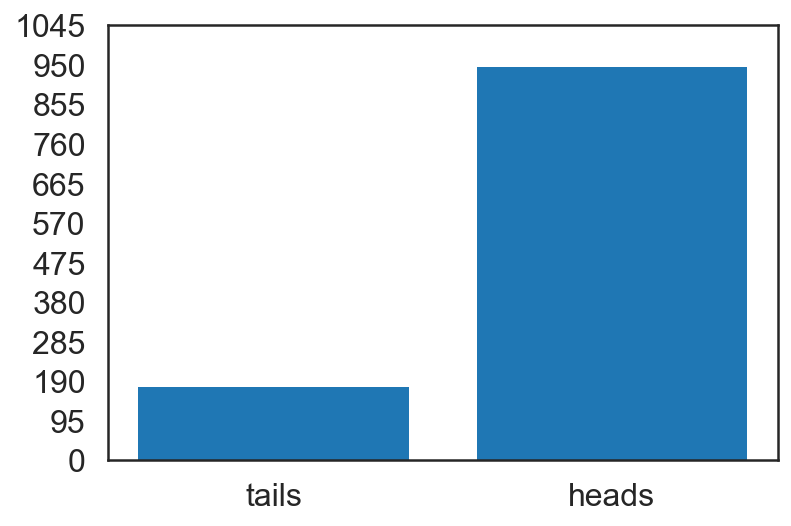

In [43]:
fig = plot_coins()
plt.show()    

## code

In [44]:
# Context manager syntax. `coin_model` is **just** 
# a placeholder
with pm.Model() as coin_model: 
    # Distributions are PyMC3 objects.
    # Specify prior using Uniform object.
    p_prior = pm.Uniform('p', 0, 1)  
    
    # Specify likelihood using Bernoulli object.
    like = pm.Bernoulli('likelihood', p=p_prior, 
                        observed=tosses)  
                        # "observed=data" is key
                        # for likelihood.

## MCMC Inference Button (TM)

In [45]:
with coin_model:
    # don't worry about this:
    step = pm.Metropolis()
    
    # focus on this, the Inference Button:
    coin_trace = pm.sample(2000, step=step)

100%|██████████| 2500/2500 [00:00<00:00, 9338.32it/s]


## results

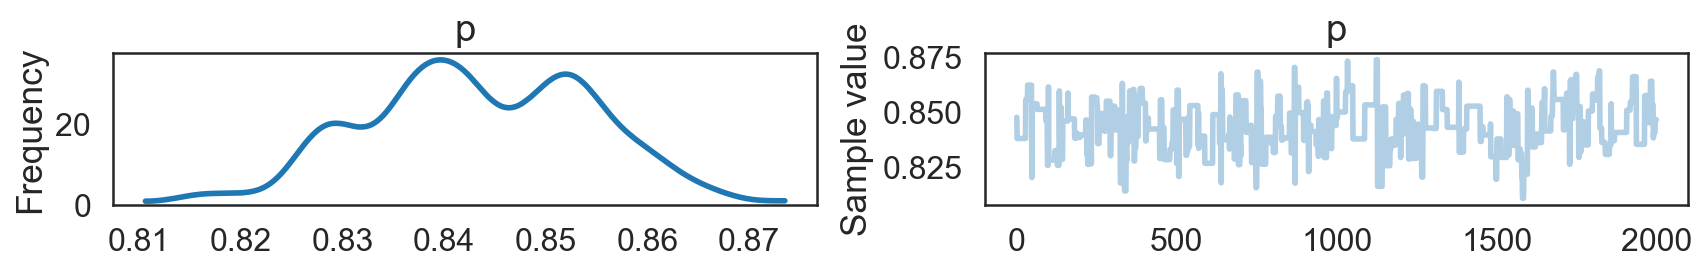

In [46]:
pm.traceplot(coin_trace)
plt.show()

#### 95% highest posterior density (HPD): 
There is a 95% chance it is in that range

The chart below presents the Mean outcome that the coin flips are heads  
and  
the percentage chance the mean is below 0.5 (one-half) and the percentage chance it is above 0.5 (one-half).

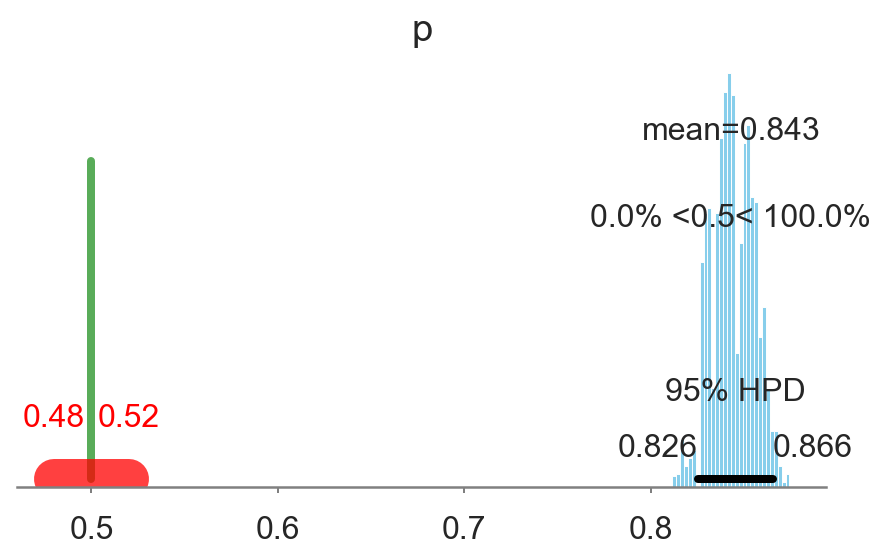

Total number of flips:  1122
Total number of heads:  946


In [47]:
pm.plot_posterior(coin_trace[100:], color='#87ceeb', 
                  rope=[0.48, 0.52], point_estimate='mean', 
                  ref_val=0.5)
plt.show()
print("Total number of flips: ", total)
print("Total number of heads: ", n_heads)


- <font style="color:black; font-weight:bold">95% highest posterior density (HPD)</font> encompasses the <font style="color:red; font-weight:bold">region of practical equivalence (ROPE)</font>. 
- GET MORE DATA!

# pattern

1. parameterize your problem using statistical distributions
1. justify your model structure
1. write model in PyMC3, hit the **Inference Button<sup>TM</sup>**
1. interpret based on posterior distributions
1. (optional) with new information, modify model structure.

# bayesian estimation

- write a **descriptive** model for how the data were generated.
    - original bayes: do this **before** seeing your data.
    - empirical bayes: do this **after** seeing your data.
- estimate **posterior distributions** of model parameters of interest.
- **deterministically compute** posterior distributions of derived parameters.

## the obligatory Bayes rule slide

$$ P(H|D) = \frac{P(D|H)P(H)}{P(D)} $$

- $ P(H|D) $: Probability that the hypothesis is true given the data.
- $ P(D|H) $: Probability of the data arising given the hypothesis.
- $ P(H) $: Probability that the hypothesis is true, globally.
- $ P(D) $: Probability of the data arising, globally.

#![](https://qph.ec.quoracdn.net/main-qimg-4f187b486bb35176d82ad942dcb20fee-c)

### Bernoulli distribution

https://en.wikipedia.org/wiki/Bernoulli_distribution

In probability theory and statistics, the Bernoulli distribution, named after Swiss mathematician Jacob Bernoulli,[1] is the probability distribution of a random variable which takes the value 1 with probability p   {\displaystyle p}  p and the value 0 with probability q = 1 − p   {\displaystyle q=1-p}  q=1-p, that is, the probability distribution of any single experiment that asks a yes–no question; the question results in a boolean-valued outcome, a single bit of information whose value is success/yes/true/one with probability p and failure/no/false/zero with probability q. It can be used to represent a coin toss where 1 and 0 would represent "head" and "tail" (or vice versa), respectively. In particular, unfair coins would have p ≠ 0.5   {\displaystyle p\neq 0.5}  p\neq 0.5.

The Bernoulli distribution is a special case of the Binomial distribution where a single experiment/trial is conducted (n=1). It is also a special case of the two-point distribution, for which the outcome need not be a bit, i.e., the two possible outcomes need not be 0 and 1.


# resources

- John K. Kruschke's [books][kruschke_books], [paper][kruschke_paper], and [video][kruschke_video].
- Statistical Re-thinking [book][mcelreath]
- Jake Vanderplas' [blog post][jakevdp_blog] on the differences between Frequentism and Bayesianism.
- PyMC3 [examples & documentation][pymc3]
- Andrew Gelman's [blog][gelman]
- Recommendations for prior distributions [wiki][priors] 
- Cam Davidson-Pilon's [Bayesian Methods for Hackers][bayes_hacks]
- Eric Ma [repository][bayes_recipes] of Bayesian data analysis recipes.

[kruschke_books]: https://sites.google.com/site/doingbayesiandataanalysis/
[kruschke_paper]: http://www.indiana.edu/~kruschke/BEST/
[kruschke_video]: https://www.youtube.com/watch?v=fhw1j1Ru2i0&feature=youtu.be
[jakevdp_blog]: http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/
[pymc3]: https://pymc-devs.github.io/pymc3/examples.html
[mcelreath]: http://xcelab.net/rm/statistical-rethinking/
[gelman]: http://andrewgelman.com/
[priors]: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
[bayes_hacks]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
[bayes_recipes]: https://github.com/ericmjl/bayesian-analysis-recipes

# GO BAYES!

- Full notebook with bonus resources: https://github.com/ericmjl/bayesian-stats-talk
- Twitter: [@ericmjl](https://twitter.com/ericmjl)
- Website: [ericmjl.com](http://www.ericmjl.com)